In [1]:
import importlib.util
def module_from_file(module_name, file_path): #The code that imports the file which originated the training with all the instructions
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            return module

from importlib import import_module
#foo = import_module(fold_folder+'/Funs.py', package=None)


folder = './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4'
foo = module_from_file("foo", f'{folder}/Funs.py')

import random as rd  
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import log_loss

tff = foo.tff # tensorflow routines 
ut = foo.ut # utilities
ln = foo.ln #Learn2_new.py
print("==Checking GPU==")
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print("==Checking CUDA==")
tf.test.is_built_with_cuda()

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.insert(1, '../ERA')

print("==Reading data==")

year_permutation = np.load(f'{folder}/year_permutation.npy')

run_vae_kwargs = ut.json2dict(f"{folder}/config.json")
T = ut.extract_nested(run_vae_kwargs, 'T')
if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    label_period_start = ut.extract_nested(run_vae_kwargs, 'label_period_start')
    label_period_end = ut.extract_nested(run_vae_kwargs, 'label_period_end')
    time_start = ut.extract_nested(run_vae_kwargs, 'time_start')
    time_end = ut.extract_nested(run_vae_kwargs, 'time_end')
    
    
n_days = time_end-time_start-T+1
n_days

2022-07-13 12:57:44.555141: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap
In this environment you cannot import Basemap


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-07-13 12:57:48.209460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


==Checking GPU==
==Checking CUDA==
==Reading data==


2022-07-13 12:57:48.215084: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-13 12:57:48.470209: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-13 12:57:48.470263: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c6420node2): /proc/driver/nvidia/version does not exist
2022-07-13 12:57:48.470286: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-13 12:57:48.473627: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


105

In [2]:
import pickle
fold = 0
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

checkpoint = 10

analogues['ind_new_tr'][checkpoint]//n_days

array([[  0, 241,   0, ..., 351,   3,  52],
       [  0,   0,  54, ..., 102, 145, 176],
       [  0,   0, 405, ..., 390, 251, 378],
       ...,
       [449,  99,  99, ...,  74, 255, 123],
       [281, 177, 241, ..., 208, 313, 198],
       [208, 241, 211, ..., 376, 209, 339]])

In [3]:
import numpy as np
#selfanalogues = (analogues['ind_new_tr'][checkpoint]//n_days)[:,0][np.newaxis].T
selfanalogues = ((np.arange(analogues['ind_new_tr'][checkpoint].shape[0]//n_days)[np.newaxis].T*np.ones((analogues['ind_new_tr'][checkpoint].shape[0]//n_days,n_days))).astype(int)).flatten()[np.newaxis].T # This is a matrix of years related to the raw index
#selfanalogues*np.ones((selfanalogues.shape[0],analogues['ind_new_tr'][checkpoint].shape[1]))
sameyear = selfanalogues*np.ones((selfanalogues.shape[0],analogues['ind_new_tr'][checkpoint].shape[1]))==analogues['ind_new_tr'][checkpoint]//n_days # A conditional matrix showing if the entry belongs to the same year 
#sameyear
noselfanalogs = (np.where(sameyear,-1,analogues['ind_new_tr'][checkpoint])) # We set to -1 all the entries that are analogs of the same year
print(np.mean(noselfanalogs == -1))

noselfanalogsmoved = []
for noselfanalogs_row in noselfanalogs: # loop over samples
    temp = np.delete(noselfanalogs_row,noselfanalogs_row==-1) # remove the values equal to -1 
    noselfanalogsmoved.append(np.pad(temp, (0,noselfanalogs_row.shape[0] - temp.shape[0]), constant_values=(noselfanalogs.shape[0],noselfanalogs.shape[0])))  # pad with the length of the time series so that if we accidently get such analog the error will be returned
noselfanalogsmoved = np.array(noselfanalogsmoved)
noselfanalogsmoved

0.011160084656084656


array([[25317, 25055, 10706, ..., 47250, 47250, 47250],
       [ 5699, 42841,  5701, ..., 47250, 47250, 47250],
       [42545,  5363,  5365, ..., 47250, 47250, 47250],
       ...,
       [10439, 10440, 26960, ..., 47250, 47250, 47250],
       [29575, 18631, 25326, ..., 20820, 47250, 47250],
       [21921, 25326, 22243, ..., 39553, 21970, 35628]])

In [27]:
import numba as nb
from numba import jit,guvectorize,set_num_threads
import numpy as np

import pickle
fold = 0
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

print(analogues['ind_new_tr'][checkpoint]//n_days)

n_Traj = range(10000) #number of trajectories for monte-carlo sampling of committor
Matr_tr = analogues['ind_new_tr'][checkpoint] #noselfanalogsmoved
Matr_va = analogues['ind_new_va'][checkpoint]
nsteps = np.arange(10) # Here we make it indices rather than steps #np.array([0,3,6,9,12,15])  #time prediction (what we call lead time tau)
chain_step = 3 # step of a Markov chain
N_Steps = T//chain_step
neighbors = [10]
time_series_tr = np.load(f"{folder}/fold_{fold}/time_series_tr.npy")
time_series_va = np.load(f"{folder}/fold_{fold}/time_series_va.npy")
threshold = np.array([2.742728328704834]) #Threshold defining committor. This parameter I don't need, I shall perhaps transform it into epochs for variational autoencoder

@guvectorize([(nb.int64,nb.int64[:],nb.int64[:],nb.int64,nb.int64,nb.int64[:,:],nb.int64[:,:],nb.float64[:,:])],'(),(n),(m),(),(),(k,o),(l,j)->(n,m)',nopython=True,target="parallel")
def SampleTraj(day,n_Traj,nsteps, nn, Markov_step, Matr_va, Matr_tr,res): # a day implies the temporal coordinates in days of the input from the 0-th year of the 1000 year long dataset
    wrong_index = 0 # This checks that during input or execution we were always working with indecies that exist in the considered matrices and we don't go below or above
    if (day >= Matr_va.shape[0]) or (day < 0): # We don't allow inputs that are outside of the range of Matr_va. 
        #print("day > Matr_va.shape[0]")
        wrong_index = 1 # manual debugging (unfortunately numba does not capture this)
        print("We don't allow inputs that are outside of the range of Matr_va")
        for l_1 in range(len(n_Traj)):
            for l_2 in range(len(nsteps)):
                res[l_1][l_2] = np.nan # we simply  don't have corresponding index
    if nn > Matr_va.shape[1]:
        wrong_index = 1 # manual debugging
        print("We don't allow inputs that are outside of the range of Matr_va")
    else:
        #print("day <= Matr_va.shape[0]")
        s_traj = np.zeros((len(n_Traj),len(nsteps))) #auxiliary variable (result)
        for l_1 in range(len(n_Traj)):
            app = rd.randint(0,nn-1) # we go randomly to the training dataset from the validation dataset without updating the time
            s = Matr_va[day][app]
            
            #print("output: ", day,app,s, Matr_va.shape)
            if (s >= Matr_tr.shape[0]) or (s < 0):
                wrong_index = 1
            for l_2 in range(len(nsteps)): 
                app = rd.randint(0,nn-1) #analogue selection
                s = Matr_tr[s][app] + Markov_step         #analog state s is evolved in time
                s_traj[l_1][l_2] = s
                if (s >= Matr_tr.shape[0]) or (s < 0):
                    wrong_index = 1
                    print("We don't allow s that are outside of the range of Matr_tr")
                if nn > Matr_tr.shape[1]:
                    wrong_index = 1 # manual debugging
                    print("We don't allow nn that are outside of the range of Matr_tr")
        #print("wrong index = ", wrong_index)
        for l_1 in range(len(n_Traj)):
            for l_2 in range(len(nsteps)):
                res[l_1][l_2] = s_traj[l_1][l_2] 
                
SampleTraj(33, range(10000),range(10), 10, 3, Matr_va, Matr_tr)

[[  0 241   0 ... 351   3  52]
 [  0   0  54 ... 102 145 176]
 [  0   0 405 ... 390 251 378]
 ...
 [449  99  99 ...  74 255 123]
 [281 177 241 ... 208 313 198]
 [208 241 211 ... 376 209 339]]


array([[26279., 36972., 36977., ...,  5138.,  5141., 21394.],
       [16910., 10868.,  3390., ...,  1127., 27191., 22357.],
       [15338., 11886., 21468., ..., 12207., 12210., 40854.],
       ...,
       [35812., 22160., 22376., ..., 40660., 29499., 29502.],
       [43061.,  7908., 26257., ..., 17373., 16147., 32549.],
       [26463., 37720., 37722., ..., 25278., 17796.,  8659.]])

In [48]:
#days = range(100)  # indices of the inputs
days = np.arange(Matr_va.shape[0])
trajs = SampleTraj(days, range(10000),range(9), 10, 3, Matr_va, Matr_tr).astype(int) # stochastic trajectories
sought_shape = list(time_series_tr[trajs].shape)
sought_shape[2] = 1
time_series=np.concatenate(((time_series_va[days][:,np.newaxis,np.newaxis,:]*np.ones(tuple(sought_shape))),time_series_tr[trajs]),axis=2) # adding the initial values to the newly generated trajectories
convolve = np.vectorize(np.convolve, signature='(n),(m)->(k)')
A = convolve(time_series[...,0],np.ones((N_Steps,))/N_Steps)[...,(N_Steps-1):-(N_Steps-1)]
time_series.shape, A.shape

((5250, 10000, 10, 3), (5250, 10000, 6))

In [49]:

time_series.reshape(-1,n_days,)[:,(label_period_start-time_start):(n_days-T+1)]

array([[ 1.48084962e+00, -1.55282907e+01, -7.22098351e-02, ...,
         4.52214890e+01,  3.96000296e-02,  5.90597343e+00],
       [ 5.90597343e+00,  1.04055588e+02, -5.73993772e-02, ...,
        -1.03901062e+02, -2.20188200e-02, -1.75345385e+00],
       [ 2.74804330e+00,  3.12493801e+01, -2.62235925e-02, ...,
        -1.97215500e+01, -6.25856500e-03,  5.90597343e+00],
       ...,
       [-2.65156776e-01,  3.49002151e+01, -2.03784695e-03, ...,
         5.28226204e+01, -3.48656289e-02,  3.39049244e+00],
       [ 1.59959018e+00,  7.97609787e+01, -1.55674908e-02, ...,
         4.61050034e+01,  1.38927046e-02, -2.65156776e-01],
       [-2.65156776e-01,  3.49002151e+01, -2.03784695e-03, ...,
         3.79699287e+01, -2.47329921e-02,  2.57947826e+00]])

In [50]:
tuple([time_series.shape[0]//n_days,-1,*time_series.shape[1:]])

(50, -1, 10000, 10, 3)

In [51]:
time_series_temp = time_series[...,0]
time_series_temp.shape

(5250, 10000, 10)

In [52]:
temp = time_series_temp.reshape(tuple([time_series_temp.shape[0]//n_days,-1,*time_series_temp.shape[1:]]))[:,(label_period_start-time_start):(n_days-T+1),...].reshape(tuple([-1,*time_series_temp.shape[2:]]))
temp.shape

(38000000, 10)

(array([2.4872000e+04, 4.0335600e+05, 2.3124920e+06, 6.5887560e+06,
        1.0964114e+07, 1.0608451e+07, 5.4170380e+06, 1.4742980e+06,
        1.9648400e+05, 1.0139000e+04]),
 array([-8.59788322, -6.79743652, -4.99698982, -3.19654312, -1.39609642,
         0.40435028,  2.20479698,  4.00524368,  5.80569038,  7.60613708,
         9.40658379]),
 <BarContainer object of 10 artists>)

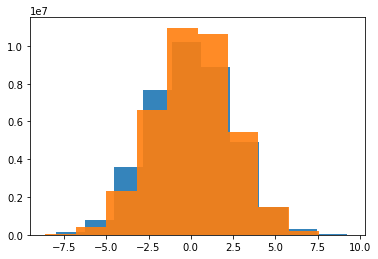

In [54]:
import matplotlib.pyplot as plt
plt.hist(temp[:,0],alpha=.9)
plt.hist(temp[:,9],alpha=.9)

(array([2.3610000e+03, 9.5068000e+04, 1.5748600e+06, 8.7869850e+06,
        1.5892482e+07, 9.4098180e+06, 2.0564530e+06, 1.7533900e+05,
        6.4420000e+03, 1.9200000e+02]),
 array([-7.29506054, -5.65622568, -4.01739082, -2.37855597, -0.73972111,
         0.89911375,  2.53794861,  4.17678347,  5.81561832,  7.45445318,
         9.09328804]),
 <BarContainer object of 10 artists>)

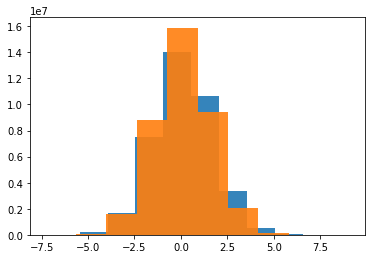

In [ ]:
tempA = A.reshape(tuple([A.shape[0]//n_days,-1,*A.shape[1:]]))[:,(label_period_start-time_start):(n_days-T+1),...].reshape(tuple([-1,*A.shape[2:]]))
tempA.shape
plt.hist(tempA[:,0],alpha=.9)
plt.hist(tempA[:,6],alpha=.9)

the number of events above the threshold steadily increases with tau which is consistent with the interpretation that the orbits diverge

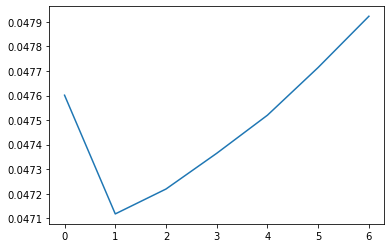

In [55]:
plt.plot([np.sum(tempA[:,i]>2.7)/len(tempA[:,i]) for i in range(7)])

In [80]:
tau = 5
tempA2 = A[...,tau].reshape(tuple([A.shape[0]//n_days,-1,*A.shape[1:-1]]))[:,(label_period_start-time_start-3*tau):(n_days-T+1-3*tau),...] #.reshape(tuple([-1,*A.shape[1:-1]]))
tempA2.shape

(50, 76, 10000)

In [81]:
np.mean(tempA2[3,3,:]>2.742728328704834)

0.0689

In [82]:
np.mean(tempA2>2.742728328704834,2).shape

(50, 76)

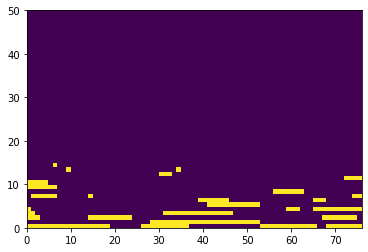

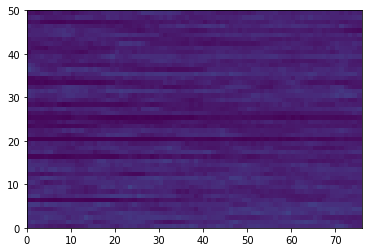

In [83]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig1, ax1 = plt.subplots()
Y_va = np.load(f'{folder}/fold_{fold}/Y_va.npy')
Y_va = Y_va.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
ax1.pcolor(Y_va, vmin=0, vmax=1)

nn = 50
tau = 0
fig2, ax2 = plt.subplots()
ax2.pcolor(np.mean(tempA2>2.742728328704834,2), vmin=0, vmax=.5)

In [84]:
percent = ut.extract_nested(run_vae_kwargs, 'percent')
entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)(Y_va.flatten(), np.mean(tempA2>2.742728328704834,2).flatten()).numpy()
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
(maxskill-entropy)/maxskill

0.041771050466387676

In [71]:
Y_va.flatten().shape

(3800,)